# Fidelity Kernel Testing

This notebook tests the functionality of the fidelity kernel in the Continuous Auto-Regression (CAR) model for multi-fidelity learning.

## 1. Import Libraries

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Add parent directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import required modules
import GaussianProcess.kernel as kernel
from GaussianProcess.cigp_v10 import cigp as GPR
from FidelityFusion_Models.MF_data import MultiFidelityDataManager
from FidelityFusion_Models.CMF_CAR import fidelity_kernel, ContinuousAutoRegression_large, train_CAR_large

# Set random seed for reproducibility
torch.manual_seed(42)

## 2. Generate Multi-Fidelity Data

We'll create synthetic data with three fidelity levels (low, medium, high) using sine functions with different characteristics.

In [5]:
# Generate the data
torch.manual_seed(1)

x_all = torch.rand(500, 1) * 20

# Low fidelity data (300 samples) - noisier
xlow_indices = torch.randperm(500)[:300]
xlow_indices = torch.sort(xlow_indices).values
x_low = x_all[xlow_indices]

# Medium fidelity data (300 samples)
xhigh1_indices = torch.randperm(500)[:300]
xhigh1_indices = torch.sort(xhigh1_indices).values
x_high1 = x_all[xhigh1_indices]

# High fidelity data (250 samples) - least noisy
xhigh2_indices = torch.randperm(500)[:250]
xhigh2_indices = torch.sort(xhigh2_indices).values
x_high2 = x_all[xhigh2_indices]

# Test data
x_test = torch.linspace(0, 20, 100).reshape(-1, 1)

# Define observations at different fidelities
y_low = torch.sin(x_low) - 0.5 * torch.sin(2 * x_low) + torch.rand(300, 1) * 0.1 - 0.05
y_high1 = torch.sin(x_high1) - 0.3 * torch.sin(2 * x_high1) + torch.rand(300, 1) * 0.05 - 0.025
y_high2 = torch.sin(x_high2) + torch.rand(250, 1) * 0.03 - 0.015
y_test = torch.sin(x_test)

# Add fidelity indicators as the last dimension
x_low = torch.cat((x_low, torch.ones(x_low.shape[0]).reshape(-1, 1)), 1)
x_high1 = torch.cat((x_high1, 2 * torch.ones(x_high1.shape[0]).reshape(-1, 1)), 1)
x_high2 = torch.cat((x_high2, 3 * torch.ones(x_high2.shape[0]).reshape(-1, 1)), 1)
x_test = torch.cat((x_test, 3 * torch.ones(x_test.shape[0]).reshape(-1, 1)), 1)

# Combine all training data
x_train = torch.cat((x_low, x_high1, x_high2), 0)
y_train = torch.cat((y_low, y_high1, y_high2), 0)

print(f"Low fidelity data shape: {x_low.shape}, {y_low.shape}")
print(f"Medium fidelity data shape: {x_high1.shape}, {y_high1.shape}")
print(f"High fidelity data shape: {x_high2.shape}, {y_high2.shape}")
print(f"Training data shape: {x_train.shape}, {y_train.shape}")
print(f"Test data shape: {x_test.shape}")

Low fidelity data shape: torch.Size([300, 2]), torch.Size([300, 1])
Medium fidelity data shape: torch.Size([300, 2]), torch.Size([300, 1])
High fidelity data shape: torch.Size([250, 2]), torch.Size([250, 1])
Training data shape: torch.Size([850, 2]), torch.Size([850, 1])
Test data shape: torch.Size([100, 2])


## 3. Visualize Training Data

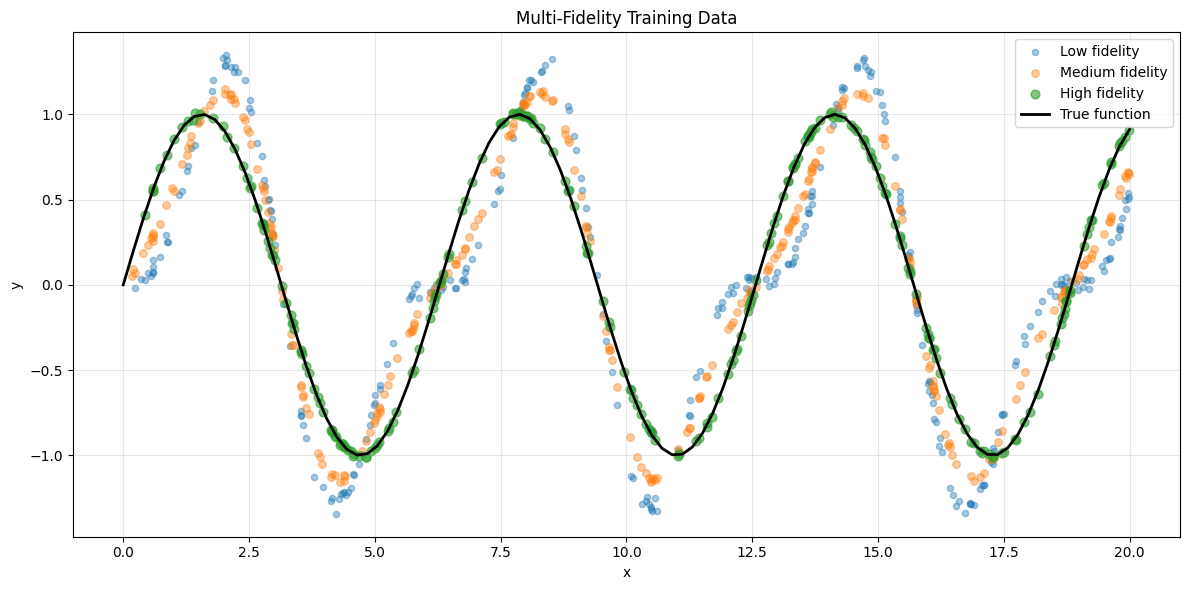

In [6]:
plt.figure(figsize=(12, 6))

# Plot training data by fidelity level
plt.scatter(x_low[:, 0], y_low, alpha=0.4, label='Low fidelity', s=20)
plt.scatter(x_high1[:, 0], y_high1, alpha=0.4, label='Medium fidelity', s=30)
plt.scatter(x_high2[:, 0], y_high2, alpha=0.6, label='High fidelity', s=40)

# Plot true function
plt.plot(x_test[:, 0], y_test, 'k-', linewidth=2, label='True function')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Multi-Fidelity Training Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Initialize the Fidelity Kernel and CAR Model

In [7]:
# Create the multi-fidelity data manager
initial_data = [
    {'raw_fidelity_name': '0', 'fidelity_indicator': 0, 'X': x_train.double(), 'Y': y_train.double()},
]

fidelity_manager = MultiFidelityDataManager(initial_data)

# Initialize the spatial kernel (ARD kernel)
kernel_x = kernel.ARDKernel(x_low.shape[1] - 1)  # -1 because last dim is fidelity indicator

# Initialize the CAR model with the fidelity kernel
CAR = ContinuousAutoRegression_large(kernel_x=kernel_x, b_init=1.0)

print("Model initialized successfully!")
print(f"\nContinuousAutoRegression_large parameters:")
for name, param in CAR.named_parameters():
    print(f"  {name}: shape {param.shape}")

Model initialized successfully!

ContinuousAutoRegression_large parameters:
  b: shape torch.Size([])
  cigp.log_beta: shape torch.Size([1])
  cigp.kernel.log_length_scales: shape torch.Size([1])
  cigp.kernel.signal_variance: shape torch.Size([1])
  cigp.kernel.k: shape torch.Size([1])
  cigp.kernel.c: shape torch.Size([1])
  cigp.kernel.kernel1.length_scales: shape torch.Size([1])
  cigp.kernel.kernel1.signal_variance: shape torch.Size([1])


## 5. Train the Model

In [8]:
# Train the CAR model
print("Training the CAR model...")
train_CAR_large(CAR, fidelity_manager, max_iter=200, lr_init=1e-2, normal=False)
print("\nTraining completed!")

Training the CAR model...


c:\Users\mn1622\OneDrive - Imperial College London\01_PhD\Projects\20_Learning\MFBO\CAMO\GaussianProcess\cigp_v10.py:63: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2270.)
  Gamma,_ = torch.triangular_solve(y_train, L, upper = False)


 ter 199 nll:-366.40197

Training completed!


## 6. Make Predictions on Test Data

In [9]:
# Make predictions
with torch.no_grad():
    y_pred, y_pred_var = CAR(fidelity_manager, x_test.double())

print(f"Predictions shape: {y_pred.shape}")
print(f"Prediction variance shape: {y_pred_var.shape}")
print(f"\nPrediction statistics:")
print(f"  Mean: {y_pred.mean():.4f}")
print(f"  Std: {y_pred.std():.4f}")
print(f"  Min: {y_pred.min():.4f}")
print(f"  Max: {y_pred.max():.4f}")

Predictions shape: torch.Size([100, 1])
Prediction variance shape: torch.Size([100, 100])

Prediction statistics:
  Mean: 0.0371
  Std: 0.6930
  Min: -0.9948
  Max: 0.9951


## 7. Visualize Predictions with Confidence Intervals

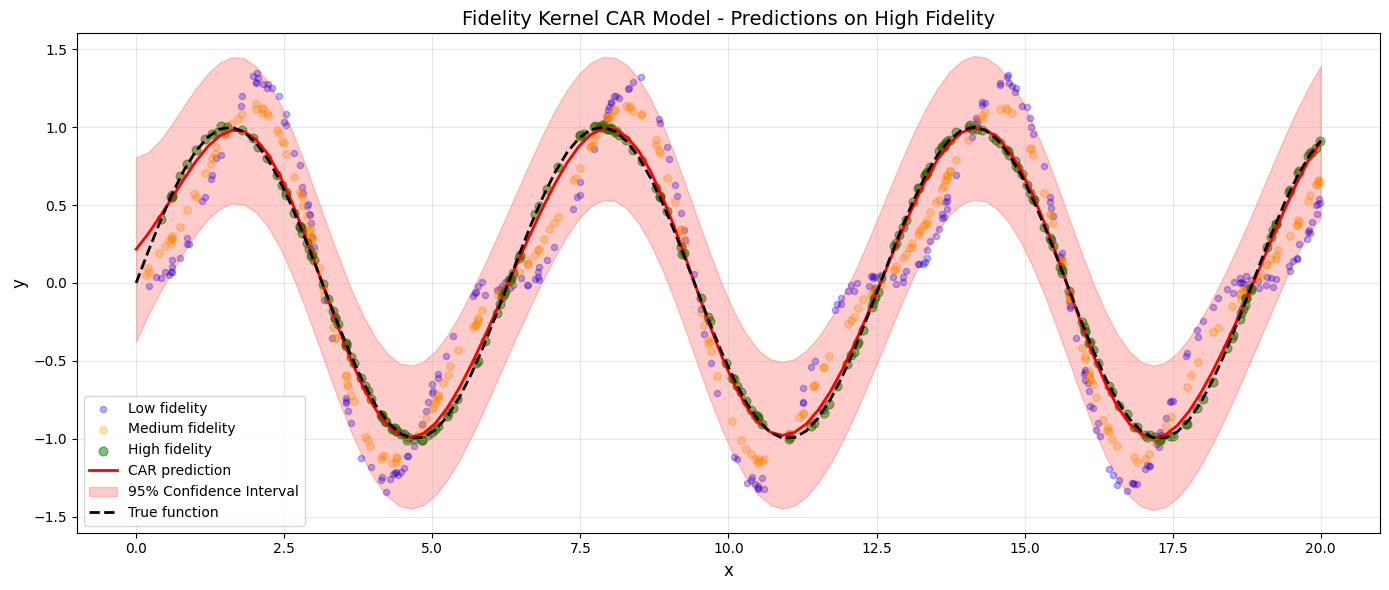

In [10]:
plt.figure(figsize=(14, 6))

# Extract prediction mean and standard deviation
x_test_np = x_test[:, 0].numpy()
y_pred_np = y_pred[:, 0].detach().numpy()
y_pred_std = np.sqrt(y_pred_var.diag().detach().numpy())
y_test_np = y_test[:, 0].numpy()

# Plot training data
plt.scatter(x_low[:, 0], y_low, alpha=0.3, s=20, label='Low fidelity', color='blue')
plt.scatter(x_high1[:, 0], y_high1, alpha=0.3, s=30, label='Medium fidelity', color='orange')
plt.scatter(x_high2[:, 0], y_high2, alpha=0.5, s=40, label='High fidelity', color='green')

# Plot predictions with confidence intervals
plt.plot(x_test_np, y_pred_np, 'r-', linewidth=2, label='CAR prediction')
plt.fill_between(
    x_test_np,
    y_pred_np - 2 * y_pred_std,
    y_pred_np + 2 * y_pred_std,
    alpha=0.2,
    color='red',
    label='95% Confidence Interval'
)

# Plot true function
plt.plot(x_test_np, y_test_np, 'k--', linewidth=2, label='True function')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Fidelity Kernel CAR Model - Predictions on High Fidelity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Compute Prediction Error Metrics

In [11]:
# Calculate error metrics
mse = torch.mean((y_pred - y_test.double()) ** 2).item()
rmse = np.sqrt(mse)
mae = torch.mean(torch.abs(y_pred - y_test.double())).item()

print(f"Prediction Error Metrics:")
print(f"  MSE (Mean Squared Error): {mse:.6f}")
print(f"  RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"  MAE (Mean Absolute Error): {mae:.6f}")

# Calculate R² score
ss_res = torch.sum((y_pred - y_test.double()) ** 2).item()
ss_tot = torch.sum((y_test.double() - y_test.double().mean()) ** 2).item()
r2_score = 1 - (ss_res / ss_tot)
print(f"  R² Score: {r2_score:.6f}")

Prediction Error Metrics:
  MSE (Mean Squared Error): 0.001725
  RMSE (Root Mean Squared Error): 0.041532
  MAE (Mean Absolute Error): 0.031638
  R² Score: 0.996472


## 9. Visualize Kernel Parameters

In [12]:
print("Fidelity Kernel Parameters:")
print(f"  log_length_scales: {CAR.cigp.kernel.log_length_scales.item():.6f}")
print(f"  length_scales: {CAR.cigp.kernel.log_length_scales.exp().item():.6f}")
print(f"  signal_variance: {CAR.cigp.kernel.signal_variance.item():.6f}")
print(f"  Decay parameter (b): {CAR.b.item():.6f}")
print(f"  Warping parameter (k): {CAR.cigp.kernel.k.item():.6f}")
print(f"  Warping parameter (c): {CAR.cigp.kernel.c.item():.6f}")

Fidelity Kernel Parameters:
  log_length_scales: 0.377624
  length_scales: 1.458815
  signal_variance: 1.287892
  Decay parameter (b): 1.447698
  Warping parameter (k): 0.402096
  Warping parameter (c): 1.598721


## 10. Test Different Fidelity Levels (Optional)

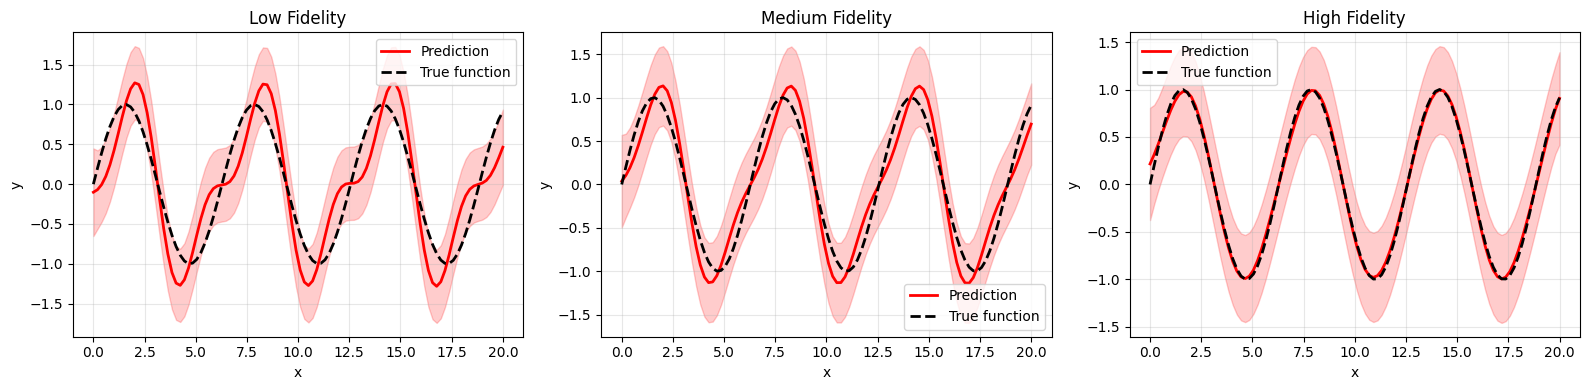

In [13]:
# Create test data at different fidelity levels
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

fidelity_levels = [1, 2, 3]  # low, medium, high
titles = ['Low Fidelity', 'Medium Fidelity', 'High Fidelity']

for ax, fidelity_level, title in zip(axes, fidelity_levels, titles):
    # Create test data for this fidelity level
    x_test_fidelity = torch.cat([
        x_test[:, :-1],
        torch.full((x_test.shape[0], 1), fidelity_level)
    ], dim=1)
    
    # Make predictions
    with torch.no_grad():
        y_pred_f, y_pred_var_f = CAR(fidelity_manager, x_test_fidelity.double())
    
    x_test_np = x_test[:, 0].numpy()
    y_pred_np = y_pred_f[:, 0].detach().numpy()
    y_pred_std = np.sqrt(y_pred_var_f.diag().detach().numpy())
    
    # Plot
    ax.plot(x_test_np, y_pred_np, 'r-', linewidth=2, label='Prediction')
    ax.fill_between(
        x_test_np,
        y_pred_np - 2 * y_pred_std,
        y_pred_np + 2 * y_pred_std,
        alpha=0.2,
        color='red'
    )
    ax.plot(x_test_np, y_test_np, 'k--', linewidth=2, label='True function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()